In [1]:
import utils
import plotting
import postprocessing
import corrections
from collections import OrderedDict

from utils import CUT_MAX_VAL, ShapeVar
from hh_vars import (
    years,
    data_key,
    qcd_key,
    bg_keys,
    samples,
    nonres_sig_keys,
    nonres_samples,
    txbb_wps,
    jec_shifts,
    jmsr_shifts,
    LUMI,
)
from postprocessing import nonres_shape_vars

import numpy as np
import pandas as pd
import pickle
from pandas.errors import SettingWithCopyWarning
from hist import Hist

import os
from copy import deepcopy
from inspect import cleandoc
import warnings

import matplotlib.pyplot as plt
import mplhep as hep
import matplotlib.ticker as mticker

plt.style.use(hep.style.CMS)
hep.style.use("CMS")
formatter = mticker.ScalarFormatter(useMathText=True)
formatter.set_powerlimits((-3, 3))
plt.rcParams.update({"font.size": 16})

# ignore these because they don't seem to apply
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
MAIN_DIR = "../../../"
samples_dir = f"{MAIN_DIR}/../data/skimmer/Feb24"
signal_samples_dir = f"{MAIN_DIR}/../data/skimmer/Jun10"
bdt_preds_dir = f"{MAIN_DIR}/../data/skimmer/Feb24/23_05_12_multiclass_rem_feats_3/inferences/"
# samples_dir = "/eos/uscms/store/user/rkansal/bbVV/skimmer/Feb24/"
# signal_samples_dir = "/eos/uscms/store/user/cmantill/bbVV/skimmer/Jun10/"
# bdt_data_dir = "/eos/uscms/store/user/cmantill/bbVV/skimmer/Jun10/bdt_data/"
year = "2018"

date = "23Nov7"
plot_dir = f"../../../plots/PostProcessing/{date}/"
templates_dir = f"templates/{date}"
_ = os.system(f"mkdir -p {plot_dir}")
_ = os.system(f"mkdir -p {plot_dir}/cutflows/")
_ = os.system(f"mkdir -p {plot_dir}/ControlPlots/{year}/")
# _ = os.system(f"mkdir -p {plot_dir}/templates/")
# _ = os.system(f"mkdir -p {plot_dir}/templates/wshifts")
# _ = os.system(f"mkdir -p {plot_dir}/templates/jshifts")
# _ = os.system(f"mkdir -p {templates_dir}")

selection_regions = postprocessing.get_nonres_selection_regions(year)

In [4]:
with open(f"{bdt_preds_dir}/{year}/sample_order.txt", "r") as f:
    BDT_sample_order = list(eval(f.read()).keys())

for key in nonres_sig_keys.copy():
    if key not in BDT_sample_order:
        del nonres_samples[key]
        nonres_sig_keys.remove(key)

for key in bg_keys.copy():
    if key not in BDT_sample_order:
        del samples[key]
        bg_keys.remove(key)

Load samples

In [5]:
filters = postprocessing.new_filters
systematics = {year: {}}

# save cutflow as pandas table
cutflow = pd.DataFrame(index=list(samples.keys()) + list(nonres_samples.keys()))

# utils.remove_empty_parquets(samples_dir, year)

# no HEM cleaning for now because it wasn't done for BDT samples
events_dict = utils.load_samples(
    signal_samples_dir, nonres_samples, year, filters, hem_cleaning=False
)
events_dict |= utils.load_samples(samples_dir, samples, year, filters, hem_cleaning=False)

utils.add_to_cutflow(events_dict, "BDTPreselection", "weight", cutflow)
cutflow

Loaded GluGluToHHTobbVV_node_cHHH1                       : 190955 entries
Loaded GluGluToHHTobbVV_node_cHHH2p45                    : 309045 entries
Loaded GluGluToHHTobbVV_node_cHHH5                       : 45022 entries
Loaded GluGluToHHTobbVV_node_cHHH0                       : 112766 entries
Loaded VBF_HHTobbVV_CV_1_C2V_0_C3_1                      : 529409 entries
Loaded VBF_HHTobbVV_CV_1_5_C2V_1_C3_1                    : 366684 entries
Loaded VBF_HHTobbVV_CV_1_C2V_1_C3_2                      : 20239 entries
Loaded VBF_HHTobbVV_CV_1_C2V_2_C3_1                      : 584319 entries
Loaded VBF_HHTobbVV_CV_1_C2V_1_C3_0                      : 18059 entries
Loaded VBF_HHTobbVV_CV_0_5_C2V_1_C3_1                    : 705871 entries
Loaded QCD_HT300to500                                    : 23 entries
Loaded QCD_HT200to300                                    : 0 entries
Loaded QCD_HT700to1000                                   : 200723 entries
Loaded QCD_HT1000to1500                           

Scale factors and bb VV assignment

In [6]:
postprocessing.apply_weights(events_dict, year, cutflow)
bb_masks = postprocessing.bb_VV_assignment(events_dict)
# events_dict[sig_key] = postprocessing.postprocess_lpsfs(events_dict[sig_key])
cutflow


QCD_SCALE_FACTOR = 1.0727354927990267


,BDTPreselection,TriggerEffs,QCD SF
QCD,3.052764e+06,1.301833e+06,1.396522e+06
TT,2.175394e+05,1.223041e+05,1.223041e+05
ST,1.517548e+04,9.009707e+03,9.009707e+03
V+Jets,8.586975e+04,4.500155e+04,4.500155e+04
Diboson,1.365254e+03,7.493028e+02,7.493028e+02
Data,1.573587e+06,1.573587e+06,1.573587e+06
HHbbVV,4.212153e+00,1.992043e+00,1.992043e+00
ggHH_kl_2p45_kt_1_HHbbVV,2.974578e+00,1.543273e+00,1.543273e+00
ggHH_kl_5_kt_1_HHbbVV,3.024268e+00,1.699298e+00,1.699298e+00
ggHH_kl_0_kt_1_HHbbVV,5.525754e+00,2.500809e+00,2.500809e+00


In [7]:
postprocessing.load_bdt_preds(events_dict, year, bdt_preds_dir, jec_jmsr_shifts=True)

Aside: checking if regressed mass is actually saving useful jets

In [ ]:
bbmsd = utils.get_feat(events_dict["HHbbVV"], "bbFatJetMsd", bb_masks["HHbbVV"])
vvmsd = utils.get_feat(events_dict["HHbbVV"], "VVFatJetMsd", bb_masks["HHbbVV"])
bbpnetm = utils.get_feat(events_dict["HHbbVV"], "bbFatJetParticleNetMass", bb_masks["HHbbVV"])
vvpnetm = utils.get_feat(events_dict["HHbbVV"], "VVFatJetParticleNetMass", bb_masks["HHbbVV"])
bbpnet = utils.get_feat(events_dict["HHbbVV"], "bbFatJetParticleNetMD_Xbb", bb_masks["HHbbVV"])
vvpart = utils.get_feat(events_dict["HHbbVV"], "VVFatJetParTMD_THWW4q", bb_masks["HHbbVV"])

In [ ]:
bbreg = (bbmsd < 50) * (bbpnetm > 50)
plt.title("Jets with Msd < 50 GeV and PNet Mass > 50 GeV")
plt.hist(bbpnet[bbreg], np.linspace(0, 1, 50), histtype="step", label="bb")
plt.xlabel("Txbb")
plt.show()

Control plots

In [ ]:
# {var: (bins, label)}
control_plot_vars = {
    # "MET_pt": ([50, 0, 300], r"$p^{miss}_T$ (GeV)"),
    # "DijetEta": ([50, -8, 8], r"$\eta^{jj}$"),
    # "DijetPt": ([50, 0, 750], r"$p_T^{jj}$ (GeV)"),
    # "DijetMass": (
    #     # list(range(800, 1400, 100)) + [1400, 1600, 2000, 3000, 4400],
    #     [40, 600, 4500],
    #     r"$m^{jj}$ (GeV)",
    # ),
    # "bbFatJetEta": ([50, -2.4, 2.4], r"$\eta^{bb}$"),
    # "bbFatJetPt": ([50, 300, 1500], r"$p^{bb}_T$ (GeV)"),
    # "bbFatJetParticleNetMass": ([20, 50, 250], r"$m^{bb}_{reg}$ (GeV)"),
    # "bbFatJetMsd": ([50, 0, 300], r"$m^{bb}_{msd}$ (GeV)"),
    # "bbFatJetParticleNetMD_Txbb": ([50, 0.8, 1], r"$T^{bb}_{Xbb}$"),
    # "VVFatJetEta": ([50, -2.4, 2.4], r"$\eta^{VV}$"),
    # "VVFatJetPt": ([50, 300, 1500], r"$p^{VV}_T$ (GeV)"),
    # "VVFatJetParticleNetMass": (
    #     # list(range(50, 110, 10)) + list(range(110, 200, 15)) + [200, 220, 250],
    #     [20, 50, 250],
    #     r"$m^{VV}_{reg}$ (GeV)",
    # ),
    # "VVFatJetMsd": ([40, 50, 250], r"$m^{VV}_{msd}$ (GeV)"),
    # "VVFatJetParticleNet_Th4q": ([50, 0, 1], r"Prob($H \to 4q$) vs Prob(QCD) (Non-MD)"),
    # "VVFatJetParTMD_THWW4q": (
    #     [50, 0, 1],
    #     r"Prob($H \to VV \to 4q$) vs Prob(QCD) (Mass-Decorrelated)",
    # ),
    # "VVFatJetParTMD_probT": ([50, 0, 1], r"Prob(Top) (Mass-Decorrelated)"),
    # "VVFatJetParTMD_THWWvsT": (
    #     [50, 0, 1],
    #     r"$T^{VV}_{HWW}$",
    # ),
    # "bbFatJetPtOverDijetPt": ([50, 0, 40], r"$p^{bb}_T / p_T^{jj}$"),
    # "VVFatJetPtOverDijetPt": ([50, 0, 40], r"$p^{VV}_T / p_T^{jj}$"),
    # "VVFatJetPtOverbbFatJetPt": ([50, 0.4, 2.0], r"$p^{VV}_T / p^{bb}_T$"),
    # "nGoodMuons": ([3, 0, 3], r"# of Muons"),
    # "nGoodElectrons": ([3, 0, 3], r"# of Electrons"),
    # "nGoodJets": ([5, 0, 5], r"# of AK4 B-Jets"),
    "BDTScore": ([50, 0, 1], r"BDT Score"),
}

hists = postprocessing.control_plots(
    events_dict,
    bb_masks,
    ["HHbbVV", "qqHH_CV_1_C2V_1_kl_1_HHbbVV"],
    control_plot_vars,
    f"{plot_dir}/ControlPlots/{year}/",
    year,
    bg_keys=["QCD", "TT", "ST", "V+Jets", "Diboson"],
    # bg_keys=["QCD", "TT", "ST", "V+Jets", "Hbb"],
    sig_scale_dict={"HHbbVV": 2e5, "qqHH_CV_1_C2V_1_kl_1_HHbbVV": 2e6},
    show=True,
)

Check BDT Sculpting

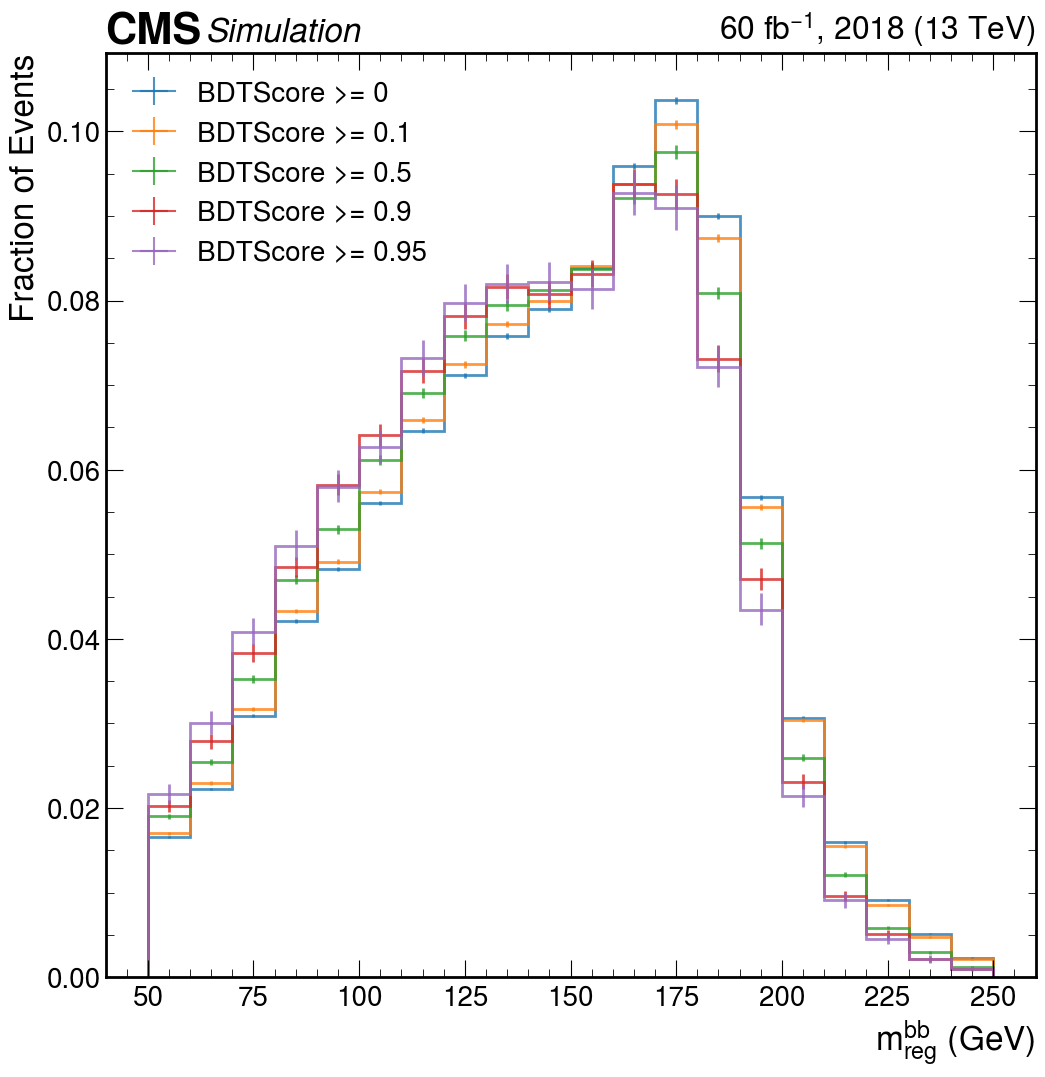

In [28]:
cuts = [0, 0.1, 0.5, 0.9, 0.95]
# bdtvars = ["", "TT", "VJets"]
bdtvars = [""]
plot_keys = ["TT"]

shape_var = ShapeVar(
    var="bbFatJetParticleNetMass", label=r"$m^{bb}_{reg}$ (GeV)", bins=[20, 50, 250]
)

for var in bdtvars:
    for key in plot_keys:
        ed_key = {key: events_dict[key]}
        bbm_key = {key: bb_masks[key]}

        fig, ax = plt.subplots(1, 1, figsize=(12, 12))
        plt.rcParams.update({"font.size": 24})

        for i, cut in enumerate(cuts):
            sel, _ = utils.make_selection({f"BDTScore{var}": [cut, CUT_MAX_VAL]}, ed_key, bbm_key)
            h = utils.singleVarHist(ed_key, shape_var, bbm_key, selection=sel)

            hep.histplot(
                h[key, ...] / np.sum(h[key, ...].values()),
                yerr=True,
                label=f"BDTScore >= {cut}",
                # density=True,
                ax=ax,
                linewidth=2,
                alpha=0.8,
            )

        ax.set_xlabel(shape_var.label)
        ax.set_ylabel("Fraction of Events")
        ax.legend()

        hep.cms.label(ax=ax, data=False, year=year, lumi=round(LUMI[year] / 1e3))
        plt.show()

In [ ]:
cuts = [0.01, 0.1, 0.5, 0.9, 0.99]
# bdtvars = ["", "TT", "VJets"]
bdtvars = [""]
sig_scales = [1e5, 5e4, 2e4, 1e4, 2e3]

# for ttcut in [0.01, 0.1, 0.5, 0.9, 0.99]:
#     ttsel, _ = utils.make_selection({"BDTScoreTT": [ttcut, CUT_MAX_VAL]}, events_dict, bb_masks)
#     cutstr = f"tt{ttcut}"

#     hists = postprocessing.control_plots(
#         events_dict,
#         bb_masks,
#         nonres_sig_keys,
#         control_plot_vars,
#         f"{plot_dir}/ControlPlots/{year}/",
#         year,
#         hists={},
#         bg_keys=["QCD", "TT", "ST", "V+Jets", "Diboson"],
#         selection=ttsel,
#         cutstr=cutstr,
#         show=True,
#     )

for var in bdtvars:
    for i, cut in enumerate(cuts):
        sel, _ = utils.make_selection({f"BDTScore{var}": [cut, CUT_MAX_VAL]}, events_dict, bb_masks)
        cutstr = f"bdt{var}{cut}"
        sig_scale = sig_scales[i]

        hists = postprocessing.control_plots(
            events_dict,
            bb_masks,
            nonres_sig_keys,
            control_plot_vars,
            f"{plot_dir}/ControlPlots/{year}/",
            year,
            hists={},
            bg_keys=["QCD", "TT", "ST", "V+Jets", "Diboson"],
            selection=sel,
            cutstr=cutstr,
            sig_scale_dict={"HHbbVV": sig_scale},
            combine_pdf=False,
            show=True,
        )

Overall BDT SF

In [ ]:
nonres_sig_keys

In [ ]:
postprocessing.lpsfs(
    events_dict,
    bb_masks,
    nonres_sig_keys,
    nonres_samples,
    cutflow,
    selection_regions["lpsf"],
    systematics,
    all_years=False,
)

In [ ]:
events = events_dict["HHbbVV"]
bb_mask = bb_masks["HHbbVV"]
weight = events["finalWeight"].values.squeeze()
weight_lp = weight * events["VV_lp_sf_nom"].values.squeeze()
weight_lp_sys_up = weight * events["VV_lp_sf_sys_up"].values.squeeze()
weight_lp_sys_down = weight * events["VV_lp_sf_sys_down"].values.squeeze()

plt.hist(
    utils.get_feat(events, "bbFatJetPt", bb_mask),
    np.linspace(250, 1200, 31),
    weights=weight,
    histtype="step",
    label="Pre-LP",
)
plt.hist(
    utils.get_feat(events, "bbFatJetPt", bb_mask),
    np.linspace(250, 1200, 31),
    weights=weight_lp,
    histtype="step",
    label="Post-LP",
)
plt.title("2018 HHbbVV")
plt.xlabel(r"$p_T^{VV}$ (GeV)")
plt.ylabel("Events")
# plt.hist(utils.get_feat(events, "VVFatJetPt", bb_mask), np.linspace(250, 2000, 31), weights=weight_lp_sys_up, histtype="step", label="Post-LP Sys Up")
# plt.hist(utils.get_feat(events, "VVFatJetPt", bb_mask), np.linspace(250, 2000, 31), weights=weight_lp_sys_down, histtype="step", label="Post-LP Sys Down")
plt.legend()

In [ ]:
list(events_dict["HHbbVV"].columns)

Templates

In [ ]:
h, tsysts = postprocessing.get_templates(
    events_dict,
    bb_masks,
    year,
    nonres_sig_keys,
    selection_regions,
    nonres_shape_vars,
    systematics,
    bg_keys=bg_keys,
    plot_dir=f"{plot_dir}/templates",
    prev_cutflow=cutflow,
    weight_shifts={},
    jshift="",
    plot_shifts=False,
    show=True,
)

In [ ]:
templates = {}

for jshift in [""] + jec_shifts + jmsr_shifts:
    print(jshift)
    ttemps, tsyst = postprocessing.get_templates(
        events_dict,
        bb_masks,
        year,
        selection_regions[year],
        shape_var,
        shape_bins,
        blind_window,
        plot_dir=plot_dir,
        prev_cutflow=cutflow,
        weight_shifts=postprocessing.weight_shifts,
        jshift=jshift,
        show=False,
    )

    templates = {**templates, **ttemps}
    systematics = {**systematics, **tsyst}

In [ ]:
systematics

In [ ]:
templates_dict = {}

for year in years:
    with open(f"templates/Feb28/{year}_templates.pkl", "rb") as f:
        templates_dict[year] = pickle.load(f)